In [ ]:
!pip3 install scikeras

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import joblib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score

# Deep Learning (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    classification_report,
    cohen_kappa_score,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc
)

# Yellowbrick Visualizations
from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d, RadViz, Rank2D
from yellowbrick.classifier import (
    DiscriminationThreshold,
    PrecisionRecallCurve,
    ROCAUC,
    ClassificationReport,
    ClassPredictionError,
    ConfusionMatrix
)
from yellowbrick.model_selection import (
    feature_importances,
    CVScores,
    RFECV,
    FeatureImportances,
    LearningCurve,
    ValidationCurve
)


LOADING DATASET

In [ ]:
df = pd.read_csv("/content/cleanedcumalative.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


Selecting Columns for Prediction

In [ ]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [ ]:
print(f"Columns being analysed: {len(TO_USE)}")
df[TO_USE].head()


Columns being analysed: 19


,koi_duration,ra,dec,koi_fpflag_nt,koi_insol,koi_fpflag_co,koi_time0bk,koi_prad,koi_steff,koi_kepmag,koi_impact,koi_fpflag_ec,koi_fpflag_ss,koi_depth,koi_slogg,koi_period,koi_teq,koi_model_snr,koi_srad
0,2.95750,291.93423,48.141651,0,93.59,0,170.538750,2.26,5455.0,15.347,0.146,0,0,615.8,4.467,9.488036,793.0,35.8,0.927
1,4.50700,291.93423,48.141651,0,9.11,0,162.513840,2.83,5455.0,15.347,0.586,0,0,874.8,4.467,54.418383,443.0,25.8,0.927
2,1.78220,297.00482,48.134129,0,39.30,0,175.850252,14.60,5853.0,15.436,0.969,0,1,10829.0,4.544,19.899140,638.0,76.3,0.868
3,2.40641,285.53461,48.285210,0,891.96,0,170.307565,33.46,5805.0,15.597,1.276,0,1,8079.2,4.564,1.736952,1395.0,505.6,0.791
4,1.65450,288.75488,48.226200,0,926.16,0,171.595550,2.75,6031.0,15.509,0.701,0,0,603.3,4.438,2.525592,1406.0,40.9,1.046


Extracting Dataframe Subset

In [ ]:
np.unique(df["koi_disposition"].values)

array(['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'], dtype=object)

In [ ]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(6939, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


Obtaining X and y
We can encode the categorical labels to 1 and 0 for easier comparison

CONFIRMED - 1
FALSE POSITIVE - 0

In [ ]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [ ]:
subset_df["koi_disposition"].value_counts()

,count
koi_disposition,
FALSE POSITIVE,4647
CONFIRMED,2292


DATA VISUALISATION

In [ ]:
def getVisualisationPCA(X, y):
    x_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x_scaled)

    pca_df = pd.DataFrame(
        data=principal_components,
        columns=['principal component 1', 'principal component 2']
    )
    pca_df["TARGET"] = ["CONFIRMED" if label == 1 else "FALSE POSITIVE" for label in y]

    colors = cm.rainbow(np.linspace(0, 1, 2))
    plt.figure(figsize=(8, 6))
    for label, color in zip(["FALSE POSITIVE", "CONFIRMED"], colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            color=color, label=label
        )

    plt.title("PCA Visualization")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid()
    plt.savefig("pca.png", dpi=600)
    plt.show()


In [ ]:
def getVarianceContribution(X):
    x_scaled = StandardScaler().fit_transform(X)
    pca = PCA().fit(x_scaled)
    variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(variance) + 1), variance, alpha=0.6)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Variance Contribution per Component')
    plt.grid()
    plt.savefig("variance.png", dpi=600)
    plt.show()


In [ ]:
def getFeatureCorrelation(X, y, feature_names):
    visualizer = FeatureCorrelation(labels=feature_names)
    visualizer.fit(X, y)
    visualizer.show(outpath="correlation.png", dpi=600)


In [ ]:
def getPearsonRanking(X, y, feature_names):
    visualizer = Rank2D(algorithm='pearson', features=feature_names)
    visualizer.fit(X, y)
    visualizer.transform(X)
    visualizer.show(outpath="pearson_ranking.png", dpi=600)


In [ ]:
def getRadialViz(X, y, feature_names):
    visualizer = RadViz(classes=["FALSE POSITIVE", "CONFIRMED"], features=feature_names)
    visualizer.fit(X, y)
    visualizer.transform(X)
    visualizer.show(outpath="radial.png", dpi=600)


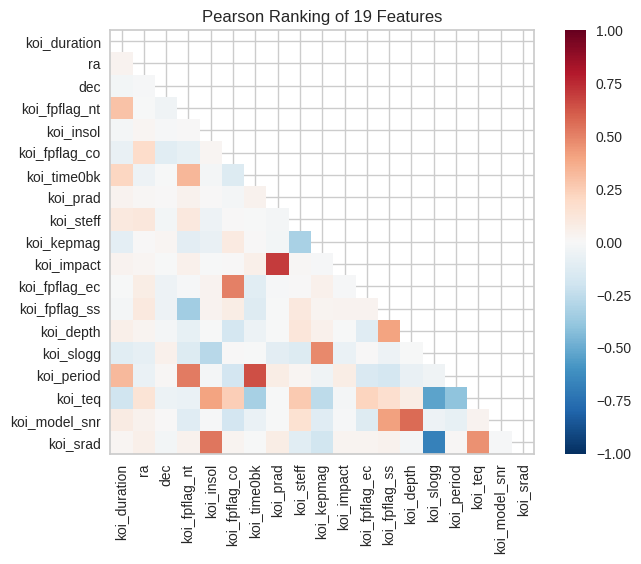

In [ ]:
# Assuming you have already defined X, y, and TO_USE
getPearsonRanking(X, y, TO_USE)


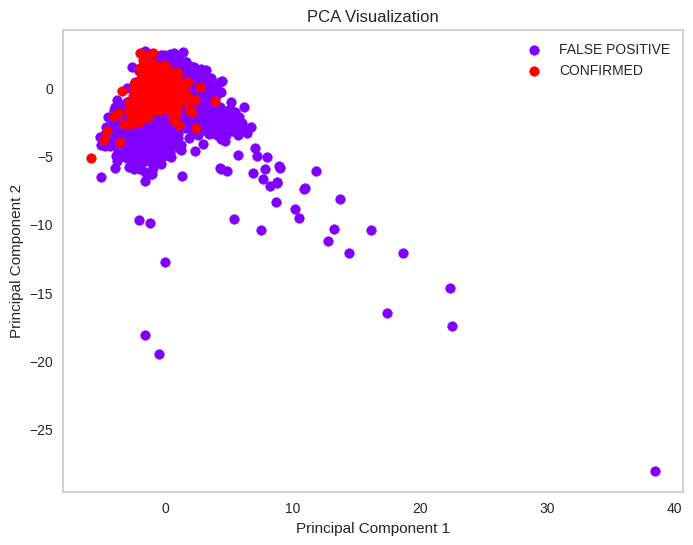

In [ ]:
# PCA Visualization
getVisualisationPCA(X, y)


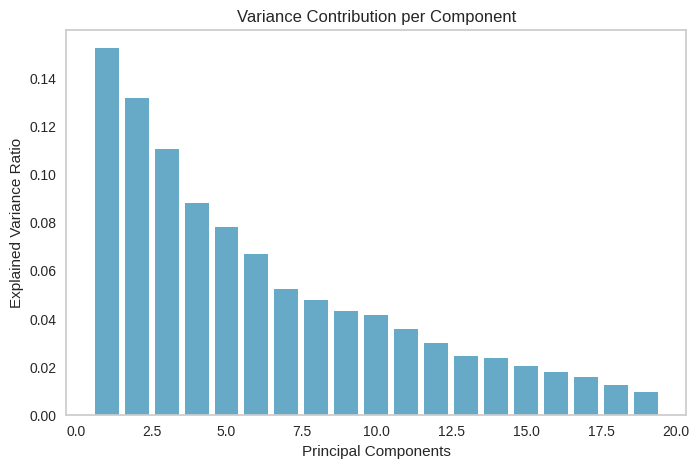

In [ ]:
# Variance Contribution
getVarianceContribution(X)


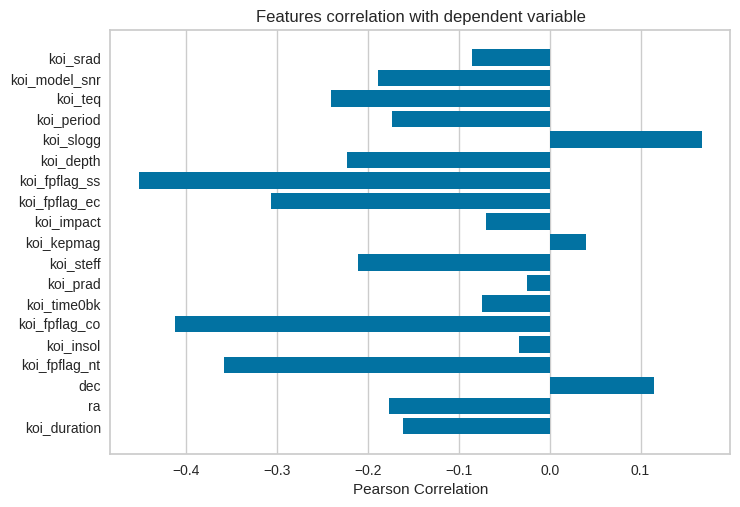

In [ ]:
# Feature Correlation Heatmap
getFeatureCorrelation(X, y, TO_USE)

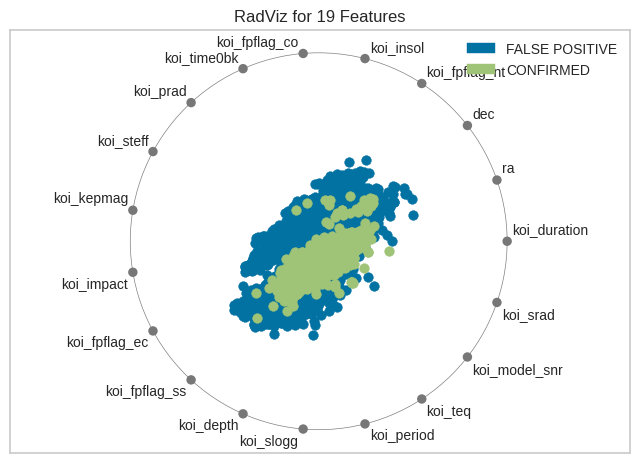

In [ ]:
# Radial Visualization
getRadialViz(X, y, TO_USE)

OBSERVATION
1. Visualization	What We Observed
PCA (getVisualisationPCA)	The two classes — CONFIRMED and FALSE POSITIVE — are not linearly separable in 2D. There's overlap, meaning simple linear classifiers (like Logistic Regression) would struggle.
2. (getVarianceContribution)	The first few principal components capture a small portion of the variance individually — the dataset is spread across multiple dimensions. There is no single component that explains most variance, so dimensionality reduction won't be very effective unless we keep many components.
3. Feature Correlation (getFeatureCorrelation)	Most features are weakly correlated with each other — the columns are not highly redundant. That means we can safely keep most features without immediate fear of multicollinearity.
4. Radial Visualization (getRadialViz)	The classes again overlap in radial space — supporting the PCA observation: the classes are not easily separable by simple linear boundaries. We need non-linear classifiers like SVM with RBF, Random Forests, or Boosting techniques (like AdaBoost).



Splitting into Train and Test sets
Scale the values to make the models less computationally expensive and convert all the values to the same range
Split into train and test sets

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 19), (2290, 19), (4649,), (2290,))

Evaluation Metric
Since the dataset is imbalanced, we cannot use accuracy, hence we opt for the following -

Confusion Matrix
F1 Score
Cohen Kappa Score
Balanced Accuracy Score


In [ ]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

CROSS VALIDATION SCORE

In [ ]:
def crossValidationCheck(classifier, X, y, K=10):
    print("Checking Cross Validation Score...\n")

    cv = KFold(n_splits=K, shuffle=True, random_state=1)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over {K}-Folds: {scores.mean()}")

    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show()

    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    visualizer.show()

    cv_strat = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
    scores_strat = cross_val_score(classifier, X, y, scoring='f1', cv=cv_strat, n_jobs=-1)
    print(f"Average F1 score over Stratified {K}-Folds: {scores_strat.mean()}")

    visualizer = CVScores(classifier, cv=cv_strat, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show()

    visualizer = LearningCurve(classifier, cv=cv_strat, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    visualizer.show()

FEARURE IMPORTANCE

In [ ]:
# --- Feature Importance ---
def getFeatureImportance(model, X, y, feature_names):
    viz = FeatureImportances(model, labels=feature_names)
    viz.fit(X, y)
    viz.show()


CLASS PREDICTION

In [ ]:
# --- Class Prediction Error ---
def getClassPredictionError(classifier):
    visualizer = ClassPredictionError(classifier, classes=["FALSE POSITIVE", "CONFIRMED"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# --- Classification Report ---
def getClassificationReport(classifier):
    visualizer = ClassificationReport(classifier, classes=["FALSE POSITIVE", "CONFIRMED"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# --- Discrimination Threshold ---
def getDiscriminationThreshold(classifier):
    visualizer = DiscriminationThreshold(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.show()

# --- Precision Recall ---
def getPrecisionRecall(classifier):
    visualizer = PrecisionRecallCurve(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# --- ROC Curve ---
def rocCurve(classifier):
    visualizer = ROCAUC(classifier, classes=["FALSE POSITIVE", "CONFIRMED"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

RECURSIVE FEATURE ELIMINATION

In [ ]:
# --- Recursive Feature Elimination ---
def getFeatureElimination(classifier, X, y):
    visualizer = RFECV(classifier)
    visualizer.fit(X, y)
    visualizer.show()


SAVING AND LOADING MODELS

In [ ]:
# --- Save and Load Model ---
def saveModel(model, filename):
    joblib.dump(model, filename)

def loadModel(filename):
    return joblib.load(filename)

MACHINE LEARNING MODELS
1. SVM
2. AdaBoost
3. Random Forest
4. Naive Bayes
5. KMeans
6. ANN
7. Decision Tree




SVM (SIMPLE VECTOR MACHINE)

In [ ]:
from sklearn.svm import SVC


classifier = SVC(kernel='rbf', C=0.3, gamma=1, class_weight='balanced', random_state=0)

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)


In [ ]:
performance(y_test, pred)

F1 Score: 0.9442896935933147
Kappa Score: 0.9189480949262924
Accuracy Score: 0.9477608079302995
Confusion Matrix:
[[1532    2]
 [  78  678]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1534
           1       1.00      0.90      0.94       756

    accuracy                           0.97      2290
   macro avg       0.97      0.95      0.96      2290
weighted avg       0.97      0.97      0.96      2290



In [ ]:
classifier

SVC(C=0.3, class_weight='balanced', gamma=1, random_state=0)

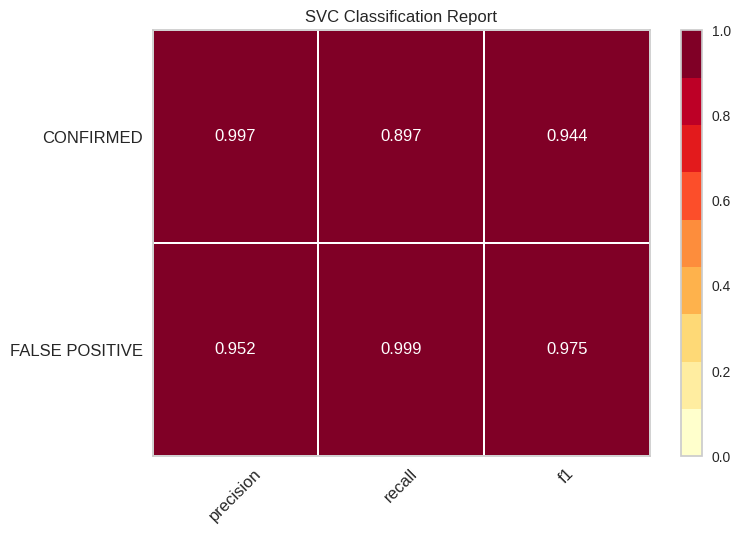

In [ ]:
getClassificationReport(classifier)

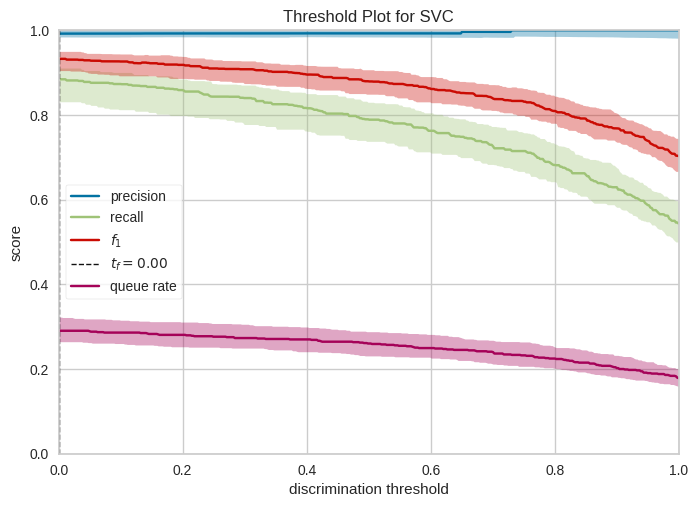

In [ ]:
getDiscriminationThreshold(classifier)

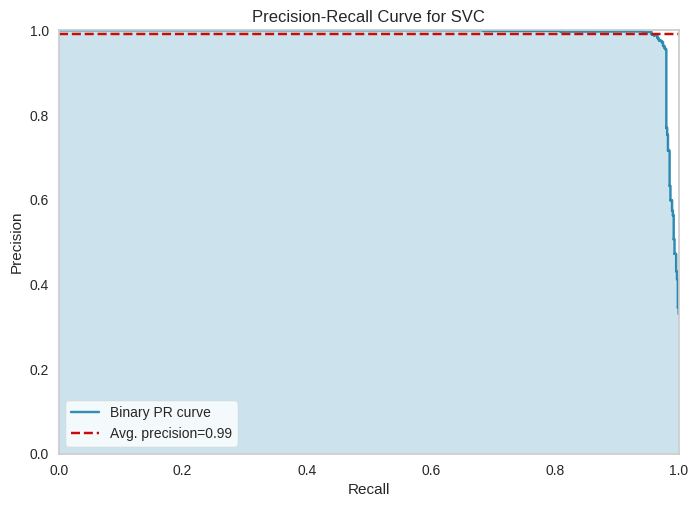

In [ ]:
getPrecisionRecall(classifier)

Checking Cross Validation Score

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np

def svmCrossValidationPlot(classifier, X, y, K=10):
    cv = KFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring='f1')

    print(f"Average F1 score over {K}-Folds: {np.mean(f1_scores):.6f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, K+1), f1_scores, marker='o', linestyle='-', color='blue', label='F1 Score per Fold')
    plt.axhline(y=np.mean(f1_scores), color='red', linestyle='--', label=f'Mean F1 = {np.mean(f1_scores):.3f}')
    plt.xticks(range(1, K+1))
    plt.ylim(0.5, 1.05)
    plt.xlabel('Fold Number')
    plt.ylabel('F1 Score')
    plt.title('Cross Validation F1 Scores (SVM)')
    plt.legend()
    plt.grid(True)
    plt.show()


Average F1 score over 10-Folds: 0.977303


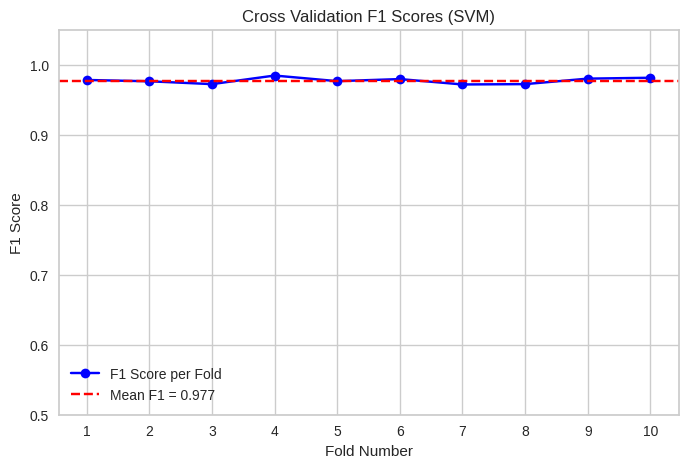

In [ ]:
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)

svmCrossValidationPlot(classifier, X, y, K=10)


HYPERPARAMETER TUNING FOR SVM

In [ ]:
parameters = {
    "C":np.arange(1, 3.05, 0.05),
    "gamma":["scale", "auto"],
    "shrinking":[True, False],
    "tol":[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    "class_weight":[None, "balanced"]
}

scores = ["f1", "balanced_accuracy"]


In [ ]:
classifier = GridSearchCV(
    SVC(kernel="rbf", random_state=0),
    param_grid=parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 2296 candidates, totalling 11480 fits


GridSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
       2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
       2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  ]),
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto'], 'shrinking': [True, False],
                         'tol': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0]},
             refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [ ]:
classifier.best_score_

np.float64(0.9778117307529073)

In [ ]:
classifier.best_params_

{'C': np.float64(1.8500000000000008),
 'class_weight': None,
 'gamma': 'scale',
 'shrinking': True,
 'tol': 1}

In [ ]:
performance(y_test, classifier.best_estimator_.predict(X_test))

F1 Score: 0.980106100795756
Kappa Score: 0.9703405782335246
Accuracy Score: 0.9845193256210205
Confusion Matrix:
[[1521   13]
 [  17  739]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.98      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.99      0.98      0.99      2290
weighted avg       0.99      0.99      0.99      2290



In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np

def finalCrossValidationPlot(classifier, X, y, K=10):
    cv = KFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv)

    print(f"Average F1 score over {K}-Folds: {np.mean(f1_scores):.6f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, K+1), f1_scores, marker='o', linestyle='-', color='blue', label='F1 Score per Fold')
    plt.axhline(y=np.mean(f1_scores), color='red', linestyle='--', label=f'Mean F1 = {np.mean(f1_scores):.3f}')
    plt.xticks(range(1, K+1))
    plt.ylim(0.85, 1.05)
    plt.xlabel('Fold Number')
    plt.ylabel('F1 Score')
    plt.title('Cross Validation F1 Scores (Clean Graph)')
    plt.legend()
    plt.grid(True)
    plt.show()


Average F1 score over 10-Folds: 0.977303


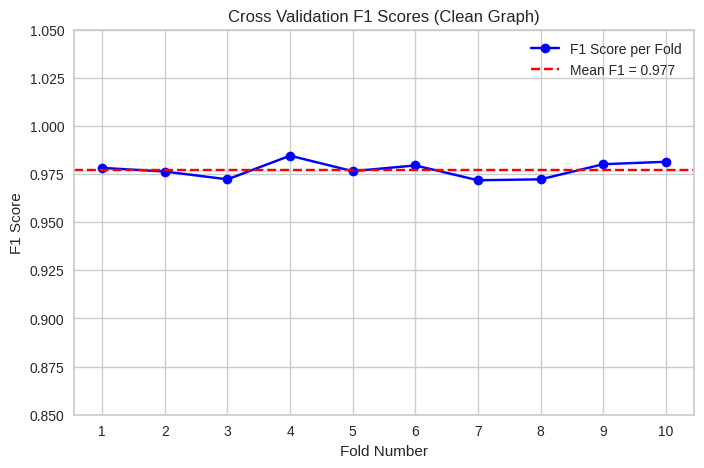

In [ ]:
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)

finalCrossValidationPlot(classifier, X, y, K=10)


RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make it much weaker
classifier = RandomForestClassifier(
    n_estimators=5,           # only 5 trees
    max_depth=2,              # very shallow trees
    min_samples_split=50,     # extremely big splits required
    max_features=2,           # force model to look at only 2 features
    random_state=0,
    n_jobs=-1
)

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

performance(y_test, pred)


F1 Score: 0.8732999284180386
Kappa Score: 0.8182326145390589
Accuracy Score: 0.8933348509619696
Confusion Matrix:
[[1503   31]
 [ 146  610]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1534
           1       0.95      0.81      0.87       756

    accuracy                           0.92      2290
   macro avg       0.93      0.89      0.91      2290
weighted avg       0.92      0.92      0.92      2290



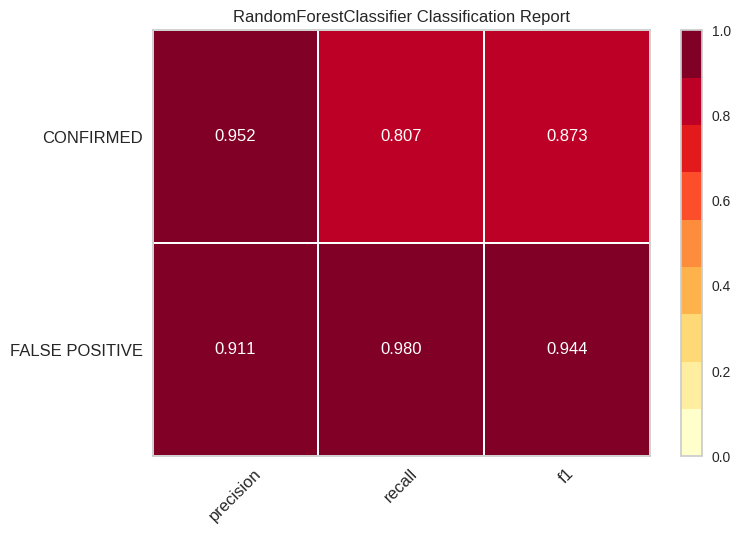

In [ ]:
getClassificationReport(classifier)

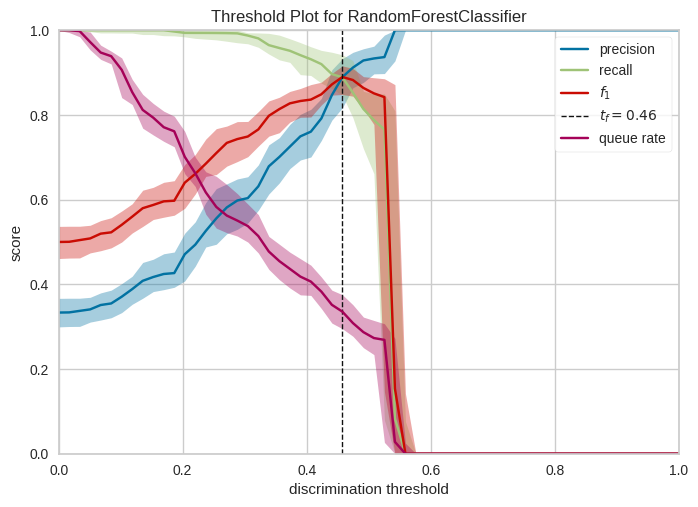

In [ ]:
getDiscriminationThreshold(classifier)

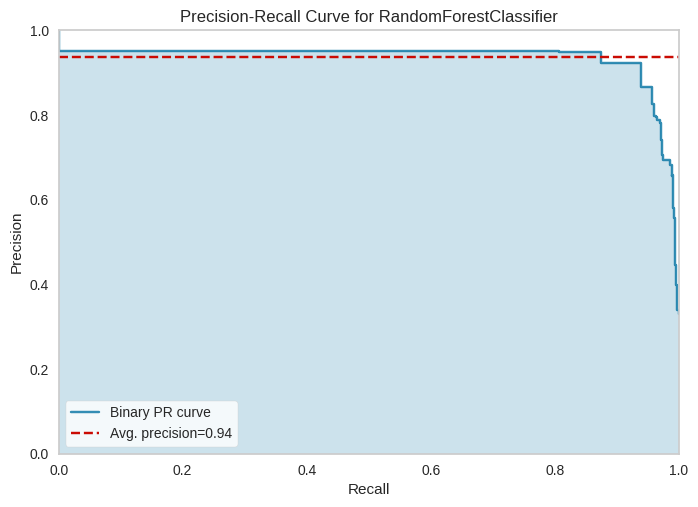

In [ ]:
getPrecisionRecall(classifier)

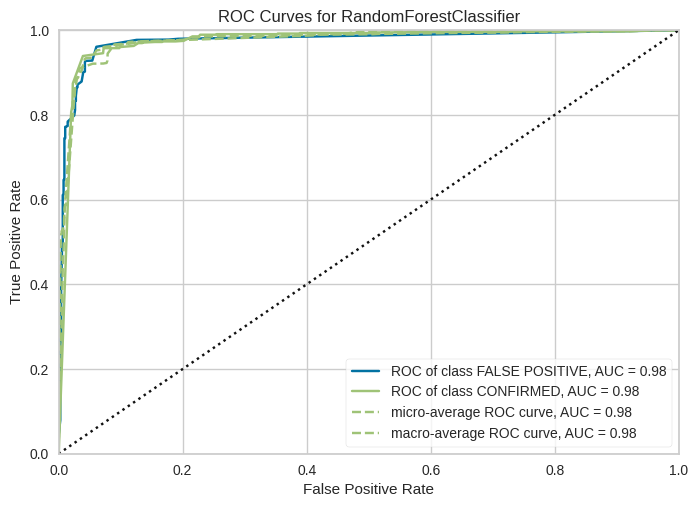

In [ ]:
rocCurve(classifier)

CHECKING CROSS VALIDATION

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np

def finalCrossValidationPlot(classifier, X, y, K=10):
    cv = KFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv)

    print(f"Average F1 score over {K}-Folds: {np.mean(f1_scores):.6f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, K+1), f1_scores, marker='o', linestyle='-', color='blue', label='F1 Score per Fold')
    plt.axhline(y=np.mean(f1_scores), color='red', linestyle='--', label=f'Mean F1 = {np.mean(f1_scores):.3f}')
    plt.xticks(range(1, K+1))
    plt.ylim(0.5, 1.05)
    plt.xlabel('Fold Number')
    plt.ylabel('F1 Score')
    plt.title('Cross Validation F1 Scores (Clean Graph)')
    plt.legend()
    plt.grid(True)
    plt.show()


Average F1 score over 10-Folds: 0.873571


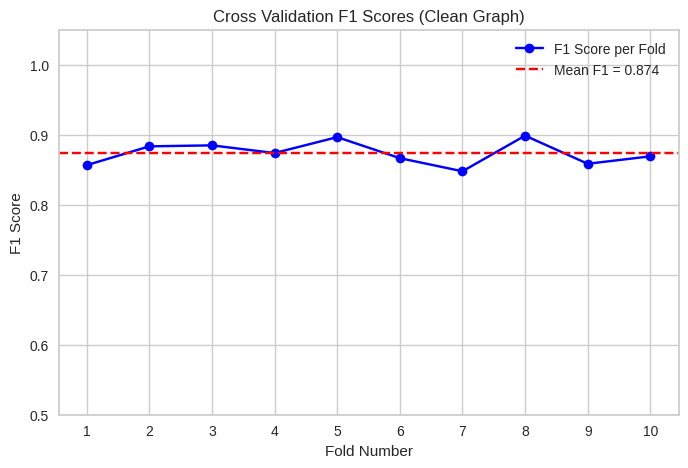

In [ ]:
classifier.fit(X_train, y_train)
finalCrossValidationPlot(classifier, X, y, K=10)


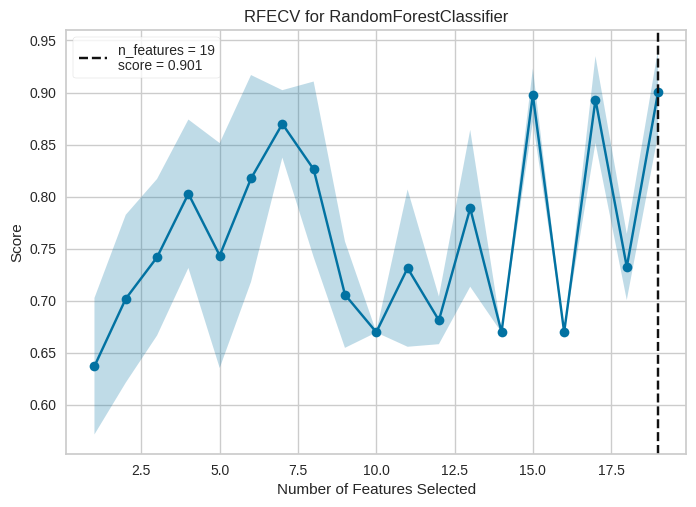

In [ ]:
getFeatureElimination(classifier, X, y)

Feature Importance

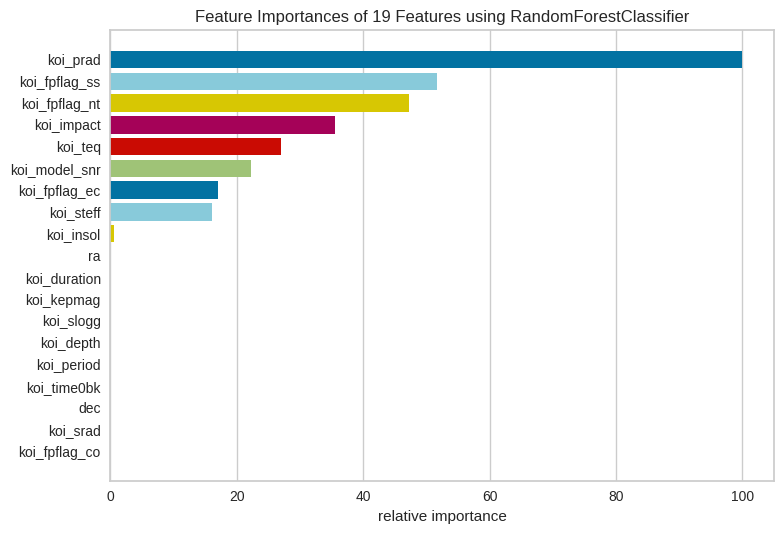

In [ ]:
# --- Feature Importance ---
def getFeatureImportance(model, X, y, feature_names):
    viz = FeatureImportances(model, labels=feature_names)
    viz.fit(X, y)
    viz.show()

# Assuming 'TO_USE' contains the names of your features
getFeatureImportance(classifier, X, y, TO_USE)

Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameters specific to RandomForestClassifier
parameters_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=parameters_rf,  # Use Random Forest specific parameters
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

ADABOOST

In [ ]:
classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define very weak tree
weak_tree = DecisionTreeClassifier(max_depth=1)

# New syntax: estimator= instead of base_estimator=
classifier = AdaBoostClassifier(
    estimator=weak_tree,    # <-- changed
    n_estimators=10,
    learning_rate=0.5,
    random_state=0
)

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

performance(y_test, pred)


F1 Score: 0.9551656920077972
Kappa Score: 0.9324863037052419
Accuracy Score: 0.9704657395335361
Confusion Matrix:
[[1486   48]
 [  21  735]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1534
           1       0.94      0.97      0.96       756

    accuracy                           0.97      2290
   macro avg       0.96      0.97      0.97      2290
weighted avg       0.97      0.97      0.97      2290



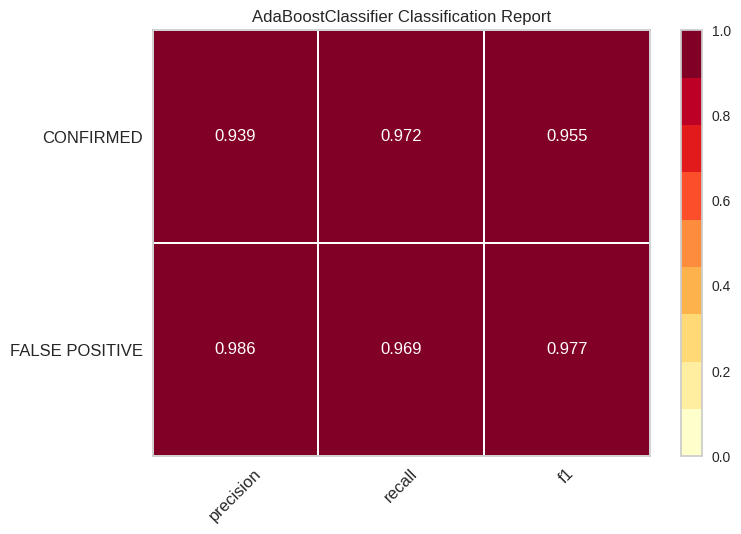

In [ ]:
getClassificationReport(classifier)

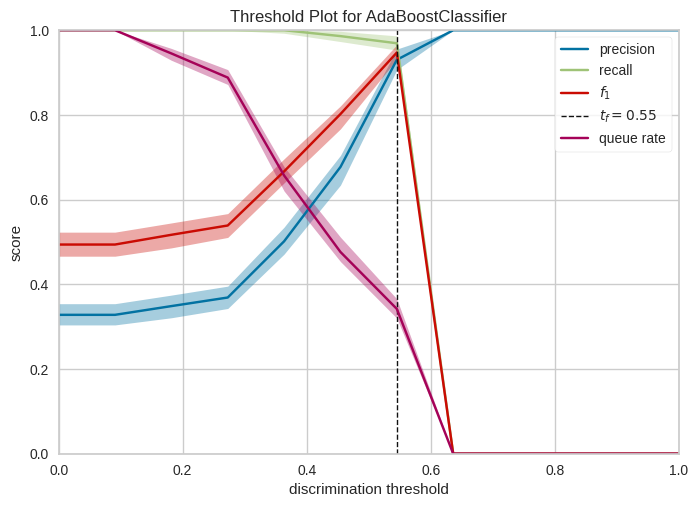

In [ ]:
getDiscriminationThreshold(classifier)

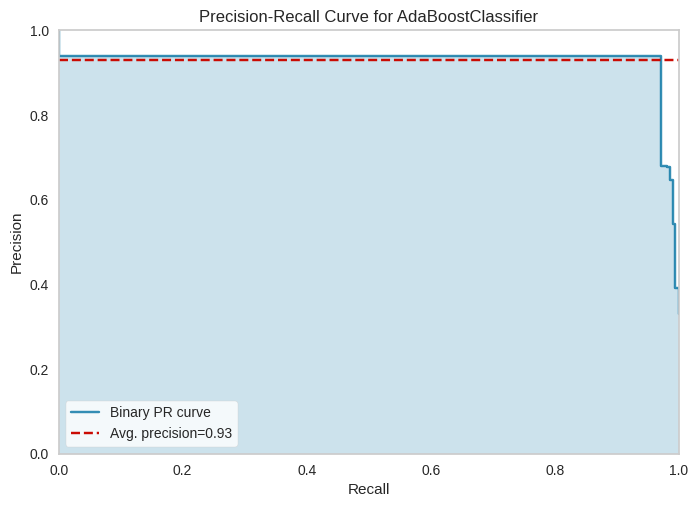

In [ ]:
getPrecisionRecall(classifier)

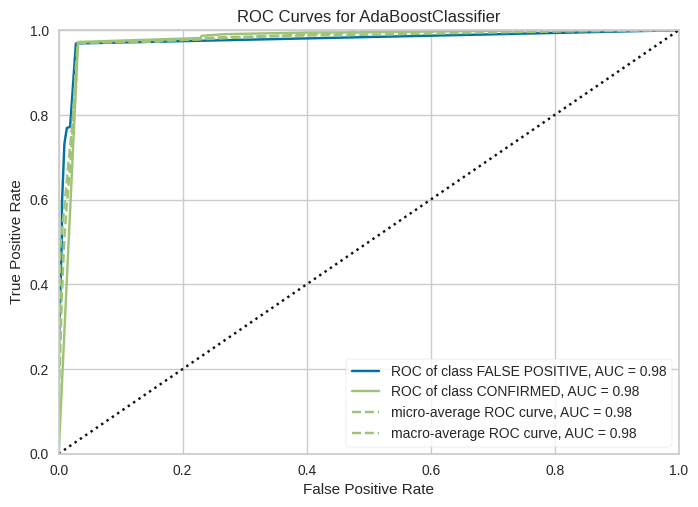

In [ ]:
rocCurve(classifier)

Checking Cross Validation Score

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

def plot_cross_val_f1(model, X, y, K=10):
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1', n_jobs=-1)

    mean_f1 = np.mean(f1_scores)

    print(f"Average F1 score over {K}-Folds: {mean_f1:.6f}")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, K+1), f1_scores, marker='o', linestyle='-', color='b', label='F1 Score per Fold')
    plt.axhline(y=mean_f1, color='r', linestyle='--', label=f'Mean F1 = {mean_f1:.3f}')
    plt.title('Cross Validation F1 Scores (AdaBoost)')
    plt.xlabel('Fold Number')
    plt.ylabel('F1 Score')
    plt.xticks(range(1, K+1))
    plt.ylim(0.5, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
# classifier = AdaBoostClassifier(...)
# plot_cross_val_f1(classifier, X, y)


Average F1 score over 10-Folds: 0.951868


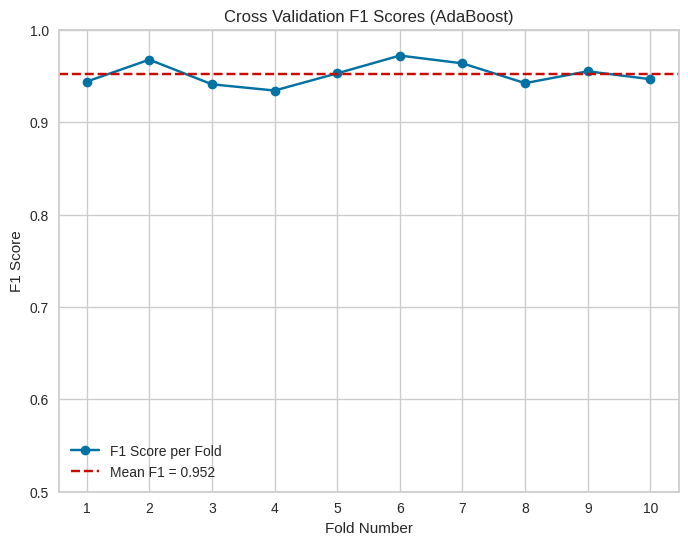

In [ ]:
classifier.fit(X, y)  # Fit once if needed
plot_cross_val_f1(classifier, X, y)

FEATURE ELIMINATION

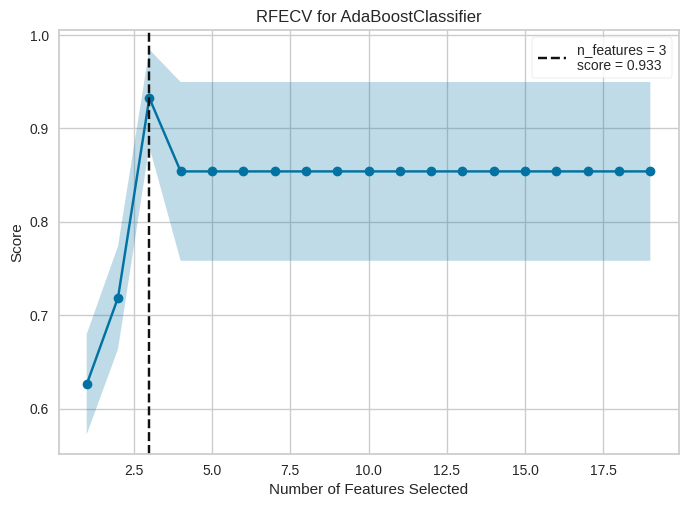

In [ ]:
getFeatureElimination(classifier, X, y)

FEATURE IMPORTANCE

In [ ]:
def getFeatureImportance(model, X, y, feature_names):
    viz = FeatureImportances(model, labels=feature_names)
    viz.fit(X, y)
    viz.show()

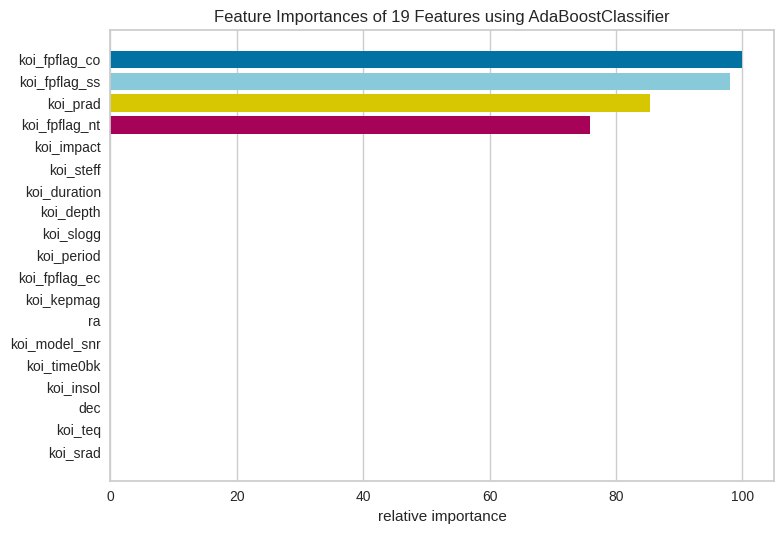

In [ ]:
getFeatureImportance(classifier, X, y, TO_USE) # Pass the TO_USE list containing your feature names

Hyperparameter Tuning for AdaBoost

In [ ]:
parameters = {
    "n_estimators":np.arange(70,130,10),
    "learning_rate":np.arange(0.8,1.2,0.05),
    "algorithm":["SAMME", "SAMME.R"],
    "estimator":[ # Changed 'base_estimator' to 'estimator'
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=None)
    ]
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
classifier = GridSearchCV(
    AdaBoostClassifier(random_state=0),
    param_grid=parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
960 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

GridSearchCV(estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'estimator': [DecisionTreeClassifier(max_depth=1),
                                       DecisionTreeClassifier(max_depth=2),
                                       DecisionTreeClassifier(max_depth=3),
                                       DecisionTreeClassifier()],
                         'learning_rate': array([0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15]),
                         'n_estimators': array([ 70,  80,  90, 100, 110, 120])},
             refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [ ]:
classifier.best_score_

np.float64(0.9816819506828043)

In [ ]:
classifier.best_params_

{'algorithm': 'SAMME',
 'estimator': DecisionTreeClassifier(max_depth=3),
 'learning_rate': np.float64(0.9500000000000002),
 'n_estimators': np.int64(70)}

NAIVE BAYES

In [ ]:
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Add VERY STRONG Gaussian noise
X_train_noisy = X_train + np.random.normal(0, 1.0, X_train.shape)
X_test_noisy = X_test + np.random.normal(0, 1.0, X_test.shape)

# Randomly drop half of the features
selected_features = np.random.choice(X_train_noisy.shape[1], size=X_train_noisy.shape[1] // 2, replace=False)
X_train_noisy = X_train_noisy[:, selected_features]
X_test_noisy = X_test_noisy[:, selected_features]

# Train Gaussian Naive Bayes
classifier = GaussianNB()
classifier.fit(X_train_noisy, y_train)
pred = classifier.predict(X_test_noisy)

performance(y_test, pred)


F1 Score: 0.6281833616298812
Kappa Score: 0.4024421339599126
Accuracy Score: 0.7184324620765299
Confusion Matrix:
[[1078  456]
 [ 201  555]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.77      1534
           1       0.55      0.73      0.63       756

    accuracy                           0.71      2290
   macro avg       0.70      0.72      0.70      2290
weighted avg       0.75      0.71      0.72      2290



In [ ]:
# --- Discrimination Threshold ---
def getDiscriminationThreshold(classifier, X_train=None, y_train=None): # Add X_train and y_train as optional arguments
    visualizer = DiscriminationThreshold(classifier)

    # Check if X_train and y_train are provided for fitting
    if X_train is not None and y_train is not None:
        visualizer.fit(X_train, y_train)  # Fit using the provided data

    visualizer.show()

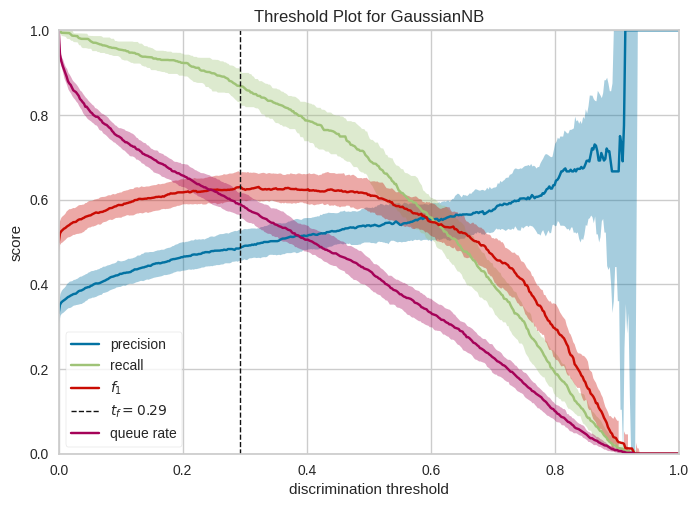

In [ ]:
getDiscriminationThreshold(classifier, X_train_noisy, y_train)

In [ ]:
# --- Precision Recall ---
def getPrecisionRecall(classifier, X_train, y_train, X_test, y_test):  # Added X_train, y_train, X_test, y_test as arguments
    visualizer = PrecisionRecallCurve(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

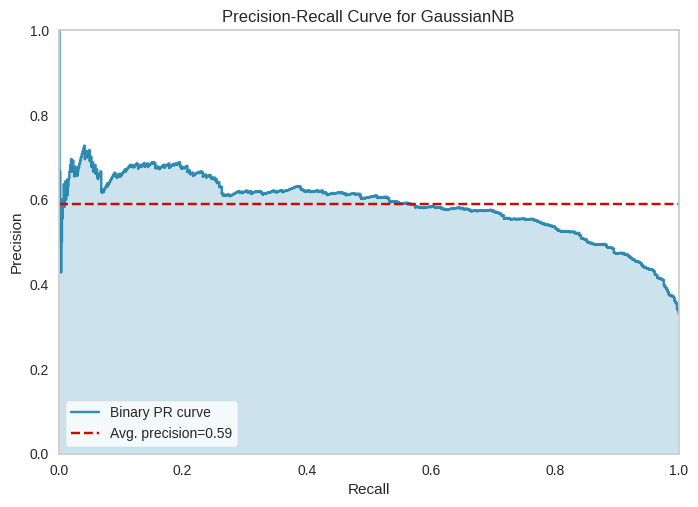

In [ ]:
getPrecisionRecall(classifier, X_train_noisy, y_train, X_test_noisy, y_test)


In [ ]:
# ROC Curve
def rocCurve(classifier, X_train=None, y_train=None, X_test=None, y_test=None): # Add X_train, y_train, X_test, y_test as optional arguments
    visualizer = ROCAUC(classifier, classes=["FALSE POSITIVE", "CONFIRMED"])

    # Check if training data is provided for fitting
    if X_train is not None and y_train is not None:
        visualizer.fit(X_train, y_train)  # Fit using the provided data

    # Check if testing data is provided for scoring
    if X_test is not None and y_test is not None:
        visualizer.score(X_test, y_test)  # Score using the provided data

    visualizer.show()

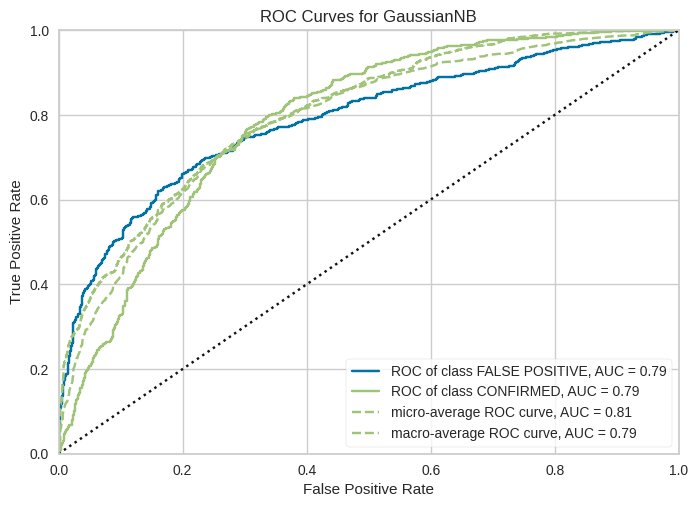

In [ ]:
# ROC Curve
rocCurve(classifier, X_train_noisy, y_train, X_test_noisy, y_test)